In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
from glob import glob
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint

In [2]:
from keras.applications.mobilenet_v3 import MobileNetV3Small

In [3]:
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

In [4]:
train_path = "/content/drive/MyDrive/program/CitrusDigipathos/augmented/train"
valid_path = "/content/drive/MyDrive/program/CitrusDigipathos/augmented/valid"
test_path = "/content/drive/MyDrive/program/CitrusDigipathos/augmented/test"

In [5]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input) \
  .flow_from_directory(directory=train_path, target_size=(224,224), classes=['Citrus canker', 'Citrus Greasy Spot', 'Citrus variegated chlorosis', 'Halo Blight', 'Mosaic', 'Nutritional Deficiency'], batch_size=32)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input) \
  .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['Citrus canker', 'Citrus Greasy Spot', 'Citrus variegated chlorosis', 'Halo Blight', 'Mosaic', 'Nutritional Deficiency'], batch_size=32)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input) \
  .flow_from_directory(directory=test_path, target_size=(224,224), classes=['Citrus canker', 'Citrus Greasy Spot', 'Citrus variegated chlorosis', 'Halo Blight', 'Mosaic', 'Nutritional Deficiency'], batch_size=32, shuffle=False)


Found 1084 images belonging to 6 classes.
Found 310 images belonging to 6 classes.
Found 151 images belonging to 6 classes.


In [6]:
imgs, labels = next(train_batches)

In [7]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


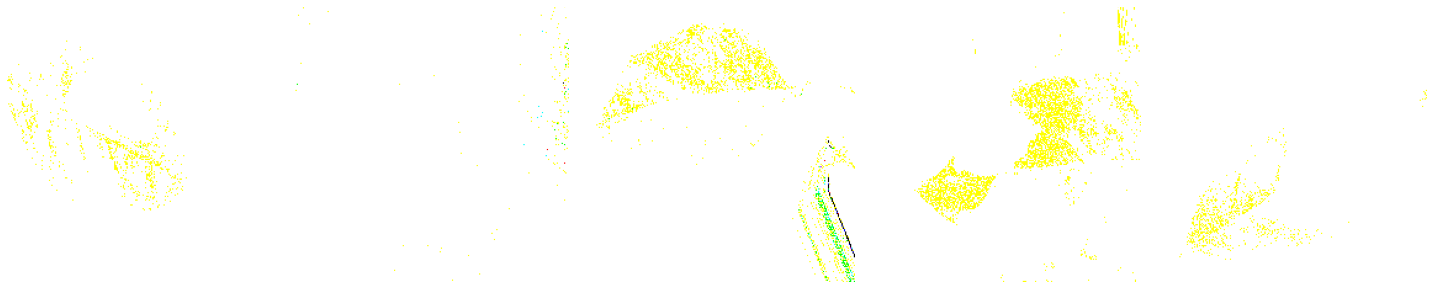

[[0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0.]]


In [8]:
plotImages(imgs)
print(labels)

In [10]:
mobilenet_model = tf.keras.applications.MobileNetV3Small()

10747904/10734624 [==============================] - 1s 0us/step


In [11]:
mobilenet_model.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 Conv (Conv2D)                  (None, None, None,   432         ['rescaling[0][0]']              
                                16)                                                

In [18]:
for layer in mobilenet_model.layers:
  layer.trainable=False
mobilenet_model.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 Conv (Conv2D)                  (None, None, None,   432         ['rescaling[0][0]']              
                                16)                                                

In [19]:
x = mobilenet_model.layers[-2].output
output = Dense(units=6, activation='softmax')(x)
model = Model(inputs=mobilenet_model.input, outputs=output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 Conv (Conv2D)                  (None, None, None,   432         ['rescaling[0][0]']              
                                16)                                                           

In [20]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer=Adam(learning_rate=0.0001),
  metrics=['accuracy']
)

In [21]:
model_path = '/content/drive/MyDrive/My ML Project /DL Project/CNN/citrusDigipathos/citrus_augmented_leaf_mobilenetV3Small_model_v1.h5'
checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', verbose=2, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [22]:
# fit the model
# Run the cell. It will take some time to execute
history = model.fit(x=train_batches,
  validation_data=valid_batches,
  epochs=10,
  callbacks=callbacks_list
)

Epoch 1/10
34/34 [==============================] - ETA: 0s - loss: 2.4091 - accuracy: 0.3173 
Epoch 1: val_accuracy improved from -inf to 0.36774, saving model to /content/drive/MyDrive/My ML Project /DL Project/CNN/citrusDigipathos/citrus_augmented_leaf_mobilenetV3Small_model_v1.h5
34/34 [==============================] - 798s 23s/step - loss: 2.4091 - accuracy: 0.3173 - val_loss: 1.7109 - val_accuracy: 0.3677
Epoch 2/10
34/34 [==============================] - ETA: 0s - loss: 1.6421 - accuracy: 0.4188
Epoch 2: val_accuracy improved from 0.36774 to 0.53871, saving model to /content/drive/MyDrive/My ML Project /DL Project/CNN/citrusDigipathos/citrus_augmented_leaf_mobilenetV3Small_model_v1.h5
34/34 [==============================] - 208s 6s/step - loss: 1.6421 - accuracy: 0.4188 - val_loss: 1.2412 - val_accuracy: 0.5387
Epoch 3/10
34/34 [==============================] - ETA: 0s - loss: 1.2817 - accuracy: 0.5203
Epoch 3: val_accuracy improved from 0.53871 to 0.67742, saving model to /

In [24]:
# fit the model
# Run the cell. It will take some time to execute
history = model.fit(x=train_batches,
  validation_data=valid_batches,
  epochs=10,
  callbacks=callbacks_list
)

Epoch 1/10
34/34 [==============================] - ETA: 0s - loss: 0.4136 - accuracy: 0.8616
Epoch 1: val_accuracy improved from 0.89032 to 0.89677, saving model to /content/drive/MyDrive/My ML Project /DL Project/CNN/citrusDigipathos/citrus_augmented_leaf_mobilenetV3Small_model_v1.h5
34/34 [==============================] - 209s 6s/step - loss: 0.4136 - accuracy: 0.8616 - val_loss: 0.3372 - val_accuracy: 0.8968
Epoch 2/10
34/34 [==============================] - ETA: 0s - loss: 0.3816 - accuracy: 0.8653
Epoch 2: val_accuracy improved from 0.89677 to 0.90000, saving model to /content/drive/MyDrive/My ML Project /DL Project/CNN/citrusDigipathos/citrus_augmented_leaf_mobilenetV3Small_model_v1.h5
34/34 [==============================] - 198s 6s/step - loss: 0.3816 - accuracy: 0.8653 - val_loss: 0.3113 - val_accuracy: 0.9000
Epoch 3/10
34/34 [==============================] - ETA: 0s - loss: 0.3588 - accuracy: 0.8801
Epoch 3: val_accuracy improved from 0.90000 to 0.90968, saving model to 

In [26]:
# fit the model
# Run the cell. It will take some time to execute
history = model.fit(x=train_batches,
  validation_data=valid_batches,
  epochs=10,
  callbacks=callbacks_list
)

Epoch 1/10
34/34 [==============================] - ETA: 0s - loss: 0.2399 - accuracy: 0.9253
Epoch 1: val_accuracy did not improve from 0.92581
34/34 [==============================] - 205s 6s/step - loss: 0.2399 - accuracy: 0.9253 - val_loss: 0.2022 - val_accuracy: 0.9258
Epoch 2/10
34/34 [==============================] - ETA: 0s - loss: 0.2376 - accuracy: 0.9197
Epoch 2: val_accuracy improved from 0.92581 to 0.93548, saving model to /content/drive/MyDrive/My ML Project /DL Project/CNN/citrusDigipathos/citrus_augmented_leaf_mobilenetV3Small_model_v1.h5
34/34 [==============================] - 198s 6s/step - loss: 0.2376 - accuracy: 0.9197 - val_loss: 0.1952 - val_accuracy: 0.9355
Epoch 3/10
34/34 [==============================] - ETA: 0s - loss: 0.2166 - accuracy: 0.9345
Epoch 3: val_accuracy improved from 0.93548 to 0.94194, saving model to /content/drive/MyDrive/My ML Project /DL Project/CNN/citrusDigipathos/citrus_augmented_leaf_mobilenetV3Small_model_v1.h5
34/34 [==============

In [28]:
# fit the model
# Run the cell. It will take some time to execute
history = model.fit(x=train_batches,
  validation_data=valid_batches,
  epochs=10,
  callbacks=callbacks_list
)

Epoch 1/10
34/34 [==============================] - ETA: 0s - loss: 0.1703 - accuracy: 0.9456
Epoch 1: val_accuracy did not improve from 0.95806
34/34 [==============================] - 202s 6s/step - loss: 0.1703 - accuracy: 0.9456 - val_loss: 0.1554 - val_accuracy: 0.9548
Epoch 2/10
34/34 [==============================] - ETA: 0s - loss: 0.1561 - accuracy: 0.9603
Epoch 2: val_accuracy improved from 0.95806 to 0.96129, saving model to /content/drive/MyDrive/My ML Project /DL Project/CNN/citrusDigipathos/citrus_augmented_leaf_mobilenetV3Small_model_v1.h5
34/34 [==============================] - 198s 6s/step - loss: 0.1561 - accuracy: 0.9603 - val_loss: 0.1506 - val_accuracy: 0.9613
Epoch 3/10
34/34 [==============================] - ETA: 0s - loss: 0.1579 - accuracy: 0.9585
Epoch 3: val_accuracy did not improve from 0.96129
34/34 [==============================] - 197s 6s/step - loss: 0.1579 - accuracy: 0.9585 - val_loss: 0.1485 - val_accuracy: 0.9581
Epoch 4/10
34/34 [===============

In [30]:
# fit the model
# Run the cell. It will take some time to execute
history = model.fit(x=train_batches,
  validation_data=valid_batches,
  epochs=10,
  callbacks=callbacks_list
)

Epoch 1/10
34/34 [==============================] - ETA: 0s - loss: 0.1226 - accuracy: 0.9640
Epoch 1: val_accuracy did not improve from 0.96452
34/34 [==============================] - 202s 6s/step - loss: 0.1226 - accuracy: 0.9640 - val_loss: 0.1267 - val_accuracy: 0.9645
Epoch 2/10
34/34 [==============================] - ETA: 0s - loss: 0.1184 - accuracy: 0.9686
Epoch 2: val_accuracy did not improve from 0.96452
34/34 [==============================] - 199s 6s/step - loss: 0.1184 - accuracy: 0.9686 - val_loss: 0.1247 - val_accuracy: 0.9613
Epoch 3/10
34/34 [==============================] - ETA: 0s - loss: 0.1191 - accuracy: 0.9613
Epoch 3: val_accuracy did not improve from 0.96452
34/34 [==============================] - 199s 6s/step - loss: 0.1191 - accuracy: 0.9613 - val_loss: 0.1230 - val_accuracy: 0.9645
Epoch 4/10
34/34 [==============================] - ETA: 0s - loss: 0.1124 - accuracy: 0.9723
Epoch 4: val_accuracy did not improve from 0.96452
34/34 [=======================

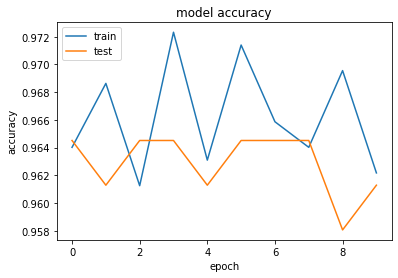

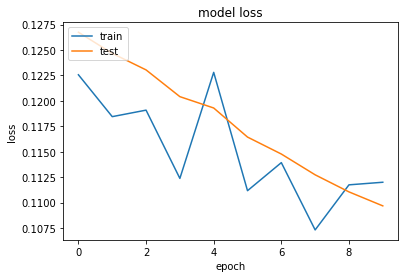

In [31]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [32]:
predictions = model.predict(x=test_batches, verbose=0)

In [33]:
rounded_predictions = np.argmax(predictions, axis=-1)

In [34]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=rounded_predictions)

In [35]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [36]:
test_batches.class_indices

{'Citrus Greasy Spot': 1,
 'Citrus canker': 0,
 'Citrus variegated chlorosis': 2,
 'Halo Blight': 3,
 'Mosaic': 4,
 'Nutritional Deficiency': 5}

Confusion matrix, without normalization
[[18  0  0  0  0  0]
 [ 0 16  0  0  0  0]
 [ 0  0 54  0  0  1]
 [ 0  0  0 10  0  0]
 [ 0  0  0  0 29  1]
 [ 0  0  3  0  0 19]]


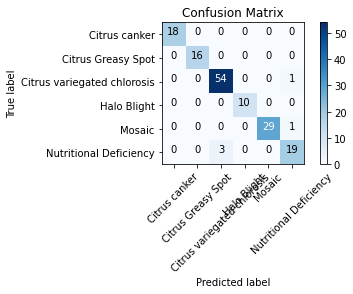

In [37]:
cm_plot_labels=['Citrus canker', 'Citrus Greasy Spot', 'Citrus variegated chlorosis', 'Halo Blight', 'Mosaic', 'Nutritional Deficiency']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [38]:
from sklearn.metrics import classification_report

In [39]:
cr = classification_report(y_true=test_batches.classes, y_pred=rounded_predictions, target_names=cm_plot_labels)
print(cr)

                             precision    recall  f1-score   support

              Citrus canker       1.00      1.00      1.00        18
         Citrus Greasy Spot       1.00      1.00      1.00        16
Citrus variegated chlorosis       0.95      0.98      0.96        55
                Halo Blight       1.00      1.00      1.00        10
                     Mosaic       1.00      0.97      0.98        30
     Nutritional Deficiency       0.90      0.86      0.88        22

                   accuracy                           0.97       151
                  macro avg       0.98      0.97      0.97       151
               weighted avg       0.97      0.97      0.97       151

